In [1]:
'''
import os
import sys
import time
import random
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
#https://pytorch.org/docs/stable/torchvision/index.html
from torchvision import transforms, models, datasets

import matplotlib.pyplot as plt
%matplotlib inline


import imageio
import warnings
import copy
import json
from PIL import Image
'''

'\nimport os\nimport sys\nimport time\nimport random\nimport numpy as np\nimport torch \nfrom torch import nn\nfrom torch.nn import functional as F\nfrom torch.utils.data import DataLoader\nimport torch.optim as optim\nimport torchvision\n#https://pytorch.org/docs/stable/torchvision/index.html\nfrom torchvision import transforms, models, datasets\n\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\n\nimport imageio\nimport warnings\nimport copy\nimport json\nfrom PIL import Image\n'

### 加载数据

In [2]:
from load_data_224 import batch_size, dataloaders, dataset_sizes, class_names

In [3]:
dataset_sizes

{'train': 5144, 'valid': 1288}

### 展示数据（im_convert？？？）

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [5]:
def im_convert(tensor):
    """ 展示数据"""
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    # [channel, h ,w] => [h, w, channel] 实际照片一般通道是在最后面的
    image = image.transpose(1,2,0)
    # 还原之前的 normalization 操作
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    # print(image.shape)

    return image

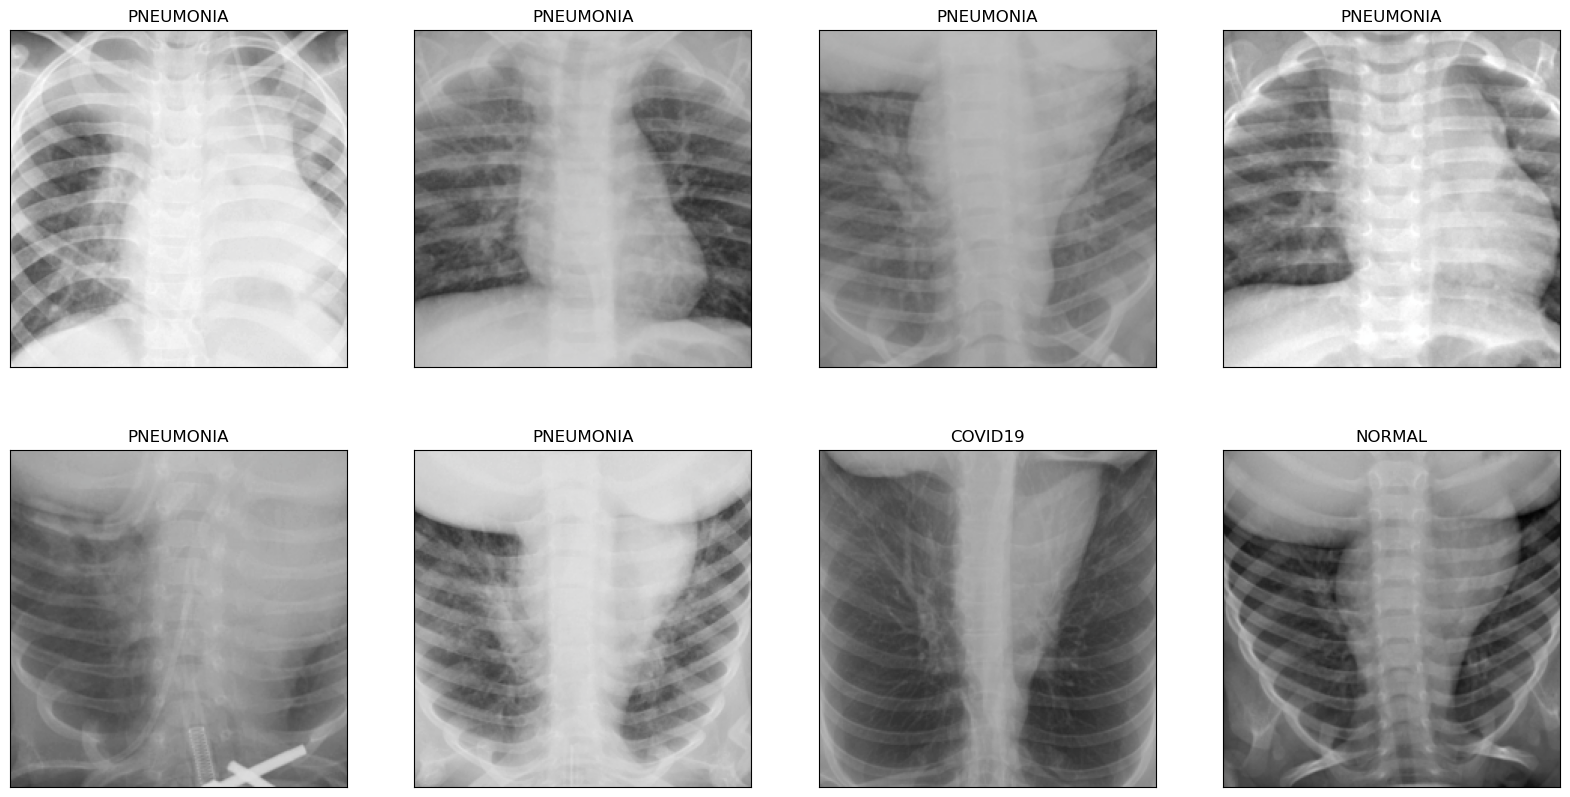

In [6]:
# figsize指定画布的大小，(宽度,高度)，单位为英寸
fig=plt.figure(figsize=(20, 10))
columns = 4
rows = 2

# dataloaders['train']：包含 train 集的所有数据 + 每个数据对应的 label
#       可以理解为数组 [num_batch, [batch_size, channel, w, h], [batch_size]]
# num_batch 表示 batch 的个数（即 num_batch = 数据量/batch_size）
'''
num_batch = 100
batch_size = 8
即总数据量为800张图片
则 
for x, label in dataloaders['train']:
    print(x.shape, label.shape)

循环 100 遍，打印：[8, c, w, h] [8] （8张图片一组）
'''

dataiter = iter(dataloaders['train'])
inputs, classes = next(dataiter)   # dataiter.next()

for idx in range (columns*rows):
    # fig.add_subplot(rows, columns, idx+1) 表示将画布 fig 分为 rows 行 columns 列（每个位置上都可以放一个子图）
    # idx+1 表示该图放在 idx+1 的位置上（即画布 fig 中对应坐标 ( (idx+1)//rows, (idx+1)%rows ) 的位置）
    # xticks=[]和yticks=[]表示子图的x轴和y轴不显示刻度
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    # 设置子图的标题
    ax.set_title(str(class_names[classes[idx]]))
    # 展示子图
    # imshow(x): 参数x表示要显示的图像数据。这通常是一个二维数组（对于灰度图像）或一个三维数组（对于RGB图像）。
    # input[idx]：获取 [batch_size, c, w, h] 中的第 idx 个 [c, w, h]
    plt.imshow(im_convert(inputs[idx]))
plt.show()

### 创建模型

In [7]:
import my_model

In [8]:
# 使用自定义的 ResNet 模型
model = my_model.ResNet()

# 打印网络模型的数据结构
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): ResBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (extra): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


#### 查看哪些层需要训练（检查是否有layer被冻结）

In [9]:
from utils import print_need_train_layer

# 检查要训练的层
print_need_train_layer(model)

Params to learn:
	 conv1.0.weight
	 conv1.0.bias
	 conv1.1.weight
	 conv1.1.bias
	 block1.conv1.weight
	 block1.conv1.bias
	 block1.bn1.weight
	 block1.bn1.bias
	 block1.conv2.weight
	 block1.conv2.bias
	 block1.bn2.weight
	 block1.bn2.bias
	 block1.extra.0.weight
	 block1.extra.0.bias
	 block1.extra.1.weight
	 block1.extra.1.bias
	 block2.conv1.weight
	 block2.conv1.bias
	 block2.bn1.weight
	 block2.bn1.bias
	 block2.conv2.weight
	 block2.conv2.bias
	 block2.bn2.weight
	 block2.bn2.bias
	 block2.extra.0.weight
	 block2.extra.0.bias
	 block2.extra.1.weight
	 block2.extra.1.bias
	 block3.conv1.weight
	 block3.conv1.bias
	 block3.bn1.weight
	 block3.bn1.bias
	 block3.conv2.weight
	 block3.conv2.bias
	 block3.bn2.weight
	 block3.bn2.bias
	 outlayer.weight
	 outlayer.bias


### 训练模型

#### 优化器设置

In [10]:
from torch import optim
from torch import nn

In [11]:
# 优化器设置
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# 学习率每 10个epoch衰减成原来的1/10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
criterion = nn.CrossEntropyLoss()


### 开始训练

In [12]:
from train_module import train_model

In [13]:
num_epochs = 30
# 模型保存地址
directory = 'checkpoint_myResnet_1_30'
filename = 'checkpoint.pth'

model_ft_1, train_history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, directory, filename)

目录 'checkpoint_myResnet_1_30' 已存在。
CUDA is available!  Training on GPU ...
Epoch 0/29
----------
Time elapsed 2m 59s
train Loss: 0.6934 Acc: 0.7315
Time elapsed 3m 34s
valid Loss: 0.5283 Acc: 0.8082
Optimizer learning rate : 0.0100000
Epoch 1/29
----------
Time elapsed 6m 9s
train Loss: 0.6043 Acc: 0.7599
Time elapsed 6m 43s
valid Loss: 0.5112 Acc: 0.7935
Optimizer learning rate : 0.0100000
Epoch 2/29
----------
Time elapsed 9m 16s
train Loss: 0.5688 Acc: 0.7741
Time elapsed 9m 49s
valid Loss: 0.4112 Acc: 0.8517
Optimizer learning rate : 0.0100000
Epoch 3/29
----------
Time elapsed 12m 30s
train Loss: 0.5192 Acc: 0.7900
Time elapsed 13m 13s
valid Loss: 1.2471 Acc: 0.4658
Optimizer learning rate : 0.0100000
Epoch 4/29
----------
Time elapsed 16m 10s
train Loss: 0.4730 Acc: 0.8124
Time elapsed 16m 44s
valid Loss: 0.8493 Acc: 0.6498
Optimizer learning rate : 0.0100000
Epoch 5/29
----------
Time elapsed 19m 20s
train Loss: 0.4686 Acc: 0.8077
Time elapsed 19m 54s
valid Loss: 0.8196 Acc: 0.6

### 展示模型训练过程

val_acc_history: [array(0.80822981), array(0.79347826), array(0.85170807), array(0.46583851), array(0.64984472), array(0.67080745), array(0.84083851), array(0.89518634), array(0.875), array(0.93322981), array(0.92779503), array(0.93478261), array(0.93400621), array(0.93944099), array(0.9371118), array(0.92701863), array(0.92701863), array(0.93555901), array(0.93555901), array(0.9386646), array(0.93555901), array(0.94021739), array(0.9386646), array(0.94332298), array(0.94487578), array(0.94099379), array(0.94254658), array(0.94254658), array(0.94254658), array(0.94177019)]
train_acc_history: [array(0.73153188), array(0.75991446), array(0.77410575), array(0.79004666), array(0.8124028), array(0.80773717), array(0.84020218), array(0.84953344), array(0.85633748), array(0.87305599), array(0.90027216), array(0.9068818), array(0.91135303), array(0.91096423), array(0.91154743), array(0.91854588), array(0.91660187), array(0.91271384), array(0.91951788), array(0.9224339), array(0.92807154), arra

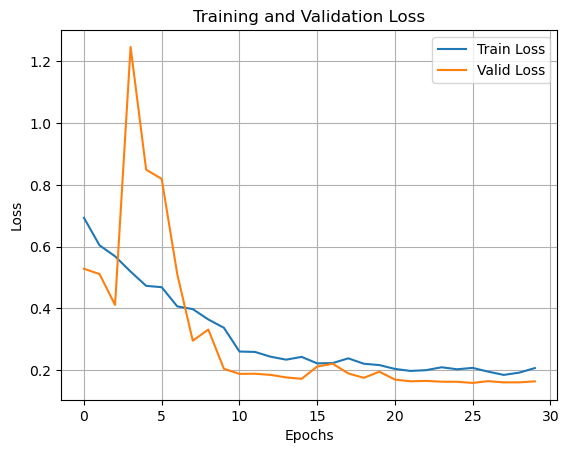

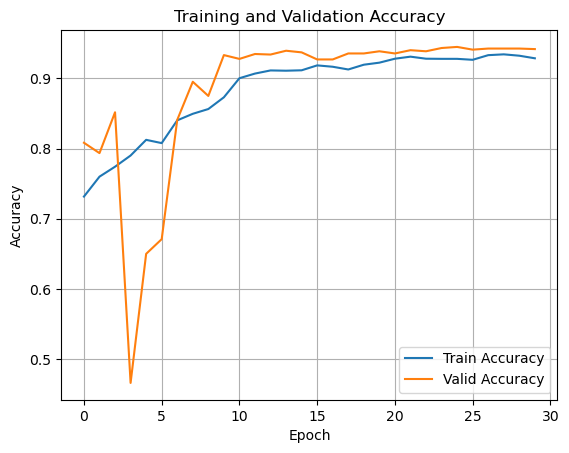

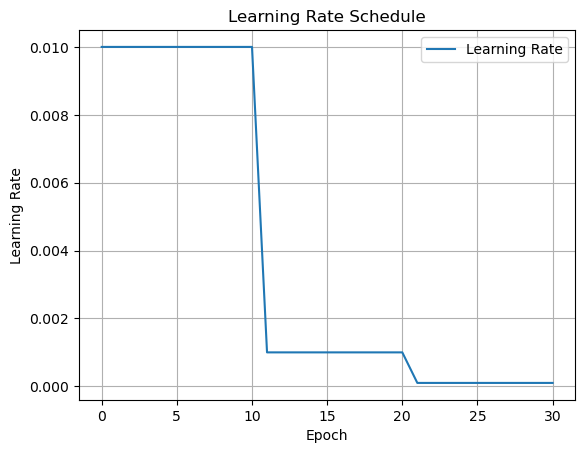

In [14]:
from utils import show_model_performace
import pickle

# 从文件中加载字典
history_filename = directory + '/train_history.pkl'
with open(history_filename, 'rb') as file:
    train_history = pickle.load(file)

# 打印加载的字典
for name, lst in train_history.items():
    print(f"{name}: {lst}")

show_model_performace(train_history, directory)

### 再次训练

加载模型

In [15]:
import torch
from torch import optim
from torch import nn

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_2 = my_model.ResNet().to(device)

optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)

# Load the checkpoint
checkpoint = torch.load(directory+'/'+filename)
best_acc = checkpoint['best_acc']
# 将之前保存的模型参数加载到新的模型对象 model_2 中，以便在新的模型上继续训练或进行推断
model_2.load_state_dict(checkpoint['state_dict'])
# 将之前保存的优化器状态加载到新的优化器对象 optimizer_2 中，以便继续使用之前的优化器状态进行参数更新
optimizer_2.load_state_dict(checkpoint['optimizer'])

# 设置新优化器的学习率衰减策略
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

criterion = nn.CrossEntropyLoss()

开始训练

In [17]:
num_epochs = 30
# 模型保存地址
directory = 'checkpoint_myResnet_2_30'
filename = 'checkpoint.pth'

model_ft_2, train_history = train_model(model_2, dataloaders, criterion, optimizer_2, scheduler_2, num_epochs, directory, filename)

目录 'checkpoint_myResnet_2_30' 已存在。
CUDA is available!  Training on GPU ...
Epoch 0/29
----------
Time elapsed 2m 22s
train Loss: 0.2012 Acc: 0.9269
Time elapsed 2m 52s
valid Loss: 0.1636 Acc: 0.9441
Optimizer learning rate : 0.0001000
Epoch 1/29
----------
Time elapsed 5m 13s
train Loss: 0.1954 Acc: 0.9273
Time elapsed 5m 43s
valid Loss: 0.1575 Acc: 0.9410
Optimizer learning rate : 0.0001000
Epoch 2/29
----------
Time elapsed 8m 3s
train Loss: 0.1948 Acc: 0.9329
Time elapsed 8m 33s
valid Loss: 0.1557 Acc: 0.9402
Optimizer learning rate : 0.0001000
Epoch 3/29
----------
Time elapsed 10m 53s
train Loss: 0.1943 Acc: 0.9302
Time elapsed 11m 22s
valid Loss: 0.1711 Acc: 0.9356
Optimizer learning rate : 0.0001000
Epoch 4/29
----------
Time elapsed 13m 39s
train Loss: 0.2024 Acc: 0.9329
Time elapsed 14m 9s
valid Loss: 0.1710 Acc: 0.9449
Optimizer learning rate : 0.0001000
Epoch 5/29
----------
Time elapsed 16m 28s
train Loss: 0.1945 Acc: 0.9304
Time elapsed 16m 57s
valid Loss: 0.1575 Acc: 0.94

展示模型训练过程

val_acc_history: [array(0.94409938), array(0.94099379), array(0.94021739), array(0.93555901), array(0.94487578), array(0.94409938), array(0.94021739), array(0.94177019), array(0.94332298), array(0.9386646), array(0.9371118), array(0.94254658), array(0.94021739), array(0.94332298), array(0.94409938), array(0.94099379), array(0.94409938), array(0.94254658), array(0.94099379), array(0.94177019), array(0.94409938), array(0.94177019), array(0.94409938), array(0.94487578), array(0.94332298), array(0.94254658), array(0.94177019), array(0.94254658), array(0.94409938), array(0.94177019)]
train_acc_history: [array(0.92690513), array(0.92729393), array(0.93293157), array(0.93020995), array(0.93293157), array(0.93040435), array(0.93215397), array(0.93468118), array(0.93137636), array(0.92826594), array(0.93487558), array(0.93370918), array(0.93079316), array(0.92904355), array(0.93312597), array(0.93409798), array(0.93098756), array(0.93176516), array(0.93643079), array(0.93409798), array(0.933125

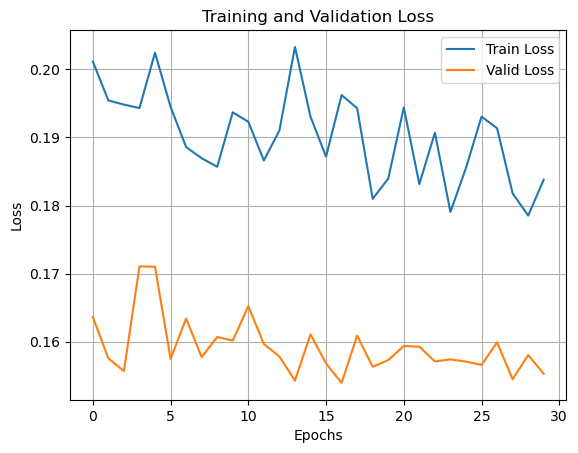

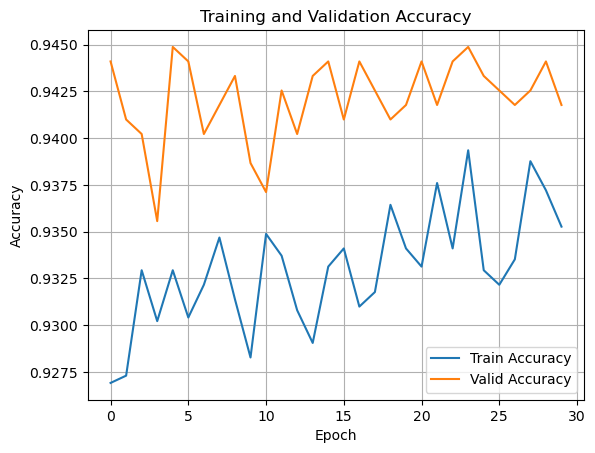

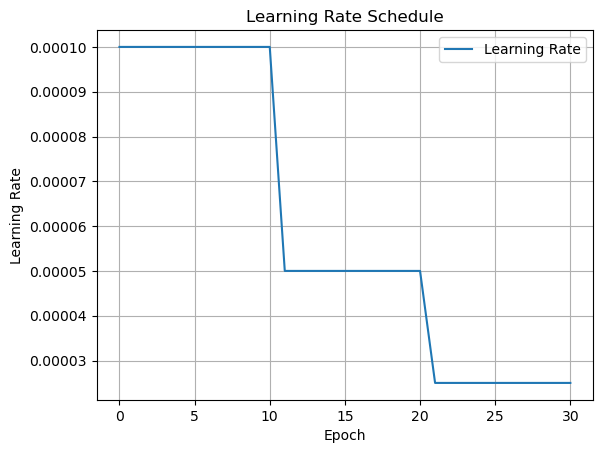

In [18]:
from utils import show_model_performace
import pickle

# 从文件中加载字典
history_filename = directory + '/train_history.pkl'
with open(history_filename, 'rb') as file:
    train_history = pickle.load(file)

# 打印加载的字典
for name, lst in train_history.items():
    print(f"{name}: {lst}")

show_model_performace(train_history, directory)